In [1]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import laplacian, grad
from pina.geometry import CartesianDomain
from pina.solvers import *
from pina.trainer import Trainer
from pina.equation import Equation
from pina.equation.equation_factory import FixedValue
from pina import Condition, Plotter
from pytorch_lightning.loggers import TensorBoardLogger
from pina.model import FeedForward
from pina.callbacks import MetricTracker

runs = 1

In [2]:
class KleinGordon(TimeDependentProblem,SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x':[-1,1],'y':[-1,1]})
    temporal_domain = CartesianDomain({'t': [0, 10]})
    def KG(input_,output_):
        u = output_.extract(['u'])
        x = input_.extract(['x'])
        y = input_.extract(['y'])
        t = input_.extract(['t'])
        u_t = grad(output_, input_, components=['u'], d=['t'])
        u_tt = grad(u_t, input_, components=['dudt'], d=['t'])
        nabla_u = laplacian(output_, input_, components=['u'], d=['x', 'y'])
        temp = (x + y) * torch.cos(2*t) + (x * y) * torch.sin(2*t)
        f = temp**2 - 4*temp
        
        return u_tt - nabla_u + u**2 - f
    def boundary_condition(input_,output_):
        u = output_.extract(['u'])
        x = input_.extract(['x'])
        y = input_.extract(['y'])
        t = input_.extract(['t'])
        temp = (x + y) * torch.cos(2*t) + (x * y) * torch.sin(2*t)
        return u - temp
        
        
    def initial_condition(input_,output_):
        x = input_.extract(['x'])
        y = input_.extract(['y'])
        u_exp = x+y
        return output_.extract(['u']) - u_exp
    
    def kg_sol(self,pts):
        x = pts.extract(['x'])
        y = pts.extract(['y'])
        t = pts.extract(['t'])
        return (x + y) * torch.cos(2*t) + (x * y) * torch.sin(2*t)
    truth_solution = kg_sol
    
    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': [-1, 1], 'y':  1, 't': [0, 10]}), equation=Equation(boundary_condition)),
        'gamma2': Condition(location=CartesianDomain({'x': [-1, 1], 'y': -1, 't': [0, 10]}), equation=Equation(boundary_condition)),
        'gamma3': Condition(location=CartesianDomain({'x':  1, 'y': [-1, 1], 't': [0, 10]}), equation=Equation(boundary_condition)),
        'gamma4': Condition(location=CartesianDomain({'x': -1, 'y': [-1, 1], 't': [0, 10]}), equation=Equation(boundary_condition)),
        't0': Condition(location=CartesianDomain({'x': [-1, 1], 'y': [-1, 1], 't': 0}), equation=Equation(initial_condition)),
        'D': Condition(location=CartesianDomain({'x': [-1, 1], 'y': [-1, 1], 't': [0, 10]}), equation=Equation(KG)),
    }

In [3]:
problem = KleinGordon()

In [4]:
problem.discretise_domain(64+64+64, 'random', locations=['D', 't0', 'gamma1', 'gamma2', 'gamma3', 'gamma4'])

In [5]:
model = FeedForward(
    layers=[64,64,64,64],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)
pinn = PINN(problem, model, optimizer_kwargs={'lr':0.001, 'weight_decay':1e-8})
gpinn = GPINN(problem, model, optimizer_kwargs={'lr':0.001, 'weight_decay':1e-8})
causalpinn = CausalPINN(problem, model, optimizer_kwargs={'lr':0.001, 'weight_decay':1e-8})
sapinin = SAPINN(problem, model)


In [6]:
import numpy as np
def error_giver(model):
    x = np.linspace(-1,1,10)
    y = np.linspace(-1,1,10)
    t = np.linspace(0,10,20)
    test_set = []
    for X in x:
        for Y in y:
            for T in t:
                test_set.append([X,Y,T])
            
    test_set = torch.Tensor(test_set)  

    predicted_output= model(test_set).detach().numpy()
    def kg_sol(pts):
        x = pts[:,0]
        y = pts[:,1]
        t = pts[:,2]
        return (x + y) * torch.cos(2*t) + (x * y) * torch.sin(2*t)
    truth_output = kg_sol(test_set).detach().numpy().reshape((100*20,1))

    error = np.linalg.norm(predicted_output-truth_output) / np.linalg.norm(truth_output)
    return error

In [7]:
for i in range(runs):
    trainer = Trainer(pinn, max_epochs=30000, callbacks=[MetricTracker()], accelerator='gpu',enable_model_summary=False,) 
    trainer.train()
    print(error_giver(model))

/home/vemuri/anaconda3/envs/pina/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/vemuri/anaconda3/envs/pina/lib/python3.11/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/vemuri/anaconda3/envs/pina/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one o

Epoch 0:   0%| | 0/1 [00:00<?, ?it/s]

/home/vemuri/anaconda3/envs/pina/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 29999: 100%|█| 1/1 [00:00<00:00

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 29999: 100%|█| 1/1 [00:00<00:00
0.1748321


In [8]:
for i in range(runs):
    trainer2 = Trainer(gpinn, max_epochs=30000, callbacks=[MetricTracker()], accelerator='gpu',enable_model_summary=False,) 
    trainer2.train()
    print(error_giver(4model))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29999: 100%|█| 1/1 [00:00<00:00

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 29999: 100%|█| 1/1 [00:00<00:00
0.12129881


In [9]:
for i in range(runs):
    trainer4 = Trainer(sapinin, max_epochs=30000, callbacks=[MetricTracker()], accelerator='gpu',enable_model_summary=False,) 
    trainer4.train()
    print(error_giver(model))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29999: 100%|█| 1/1 [00:00<00:00

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 29999: 100%|█| 1/1 [00:00<00:00
0.18318304


In [10]:
"""
for i in range(runs):
    trainer3 = Trainer(causalpinn, max_epochs=30000, callbacks=[MetricTracker()], accelerator='gpu',enable_model_summary=False,) 
    trainer3.train()
    print(error_giver(model))
"""

"\nfor i in range(runs):\n    trainer3 = Trainer(causalpinn, max_epochs=30000, callbacks=[MetricTracker()], accelerator='gpu',enable_model_summary=False,) \n    trainer3.train()\n    print(error_giver(model))\n"

Plotting at t=0


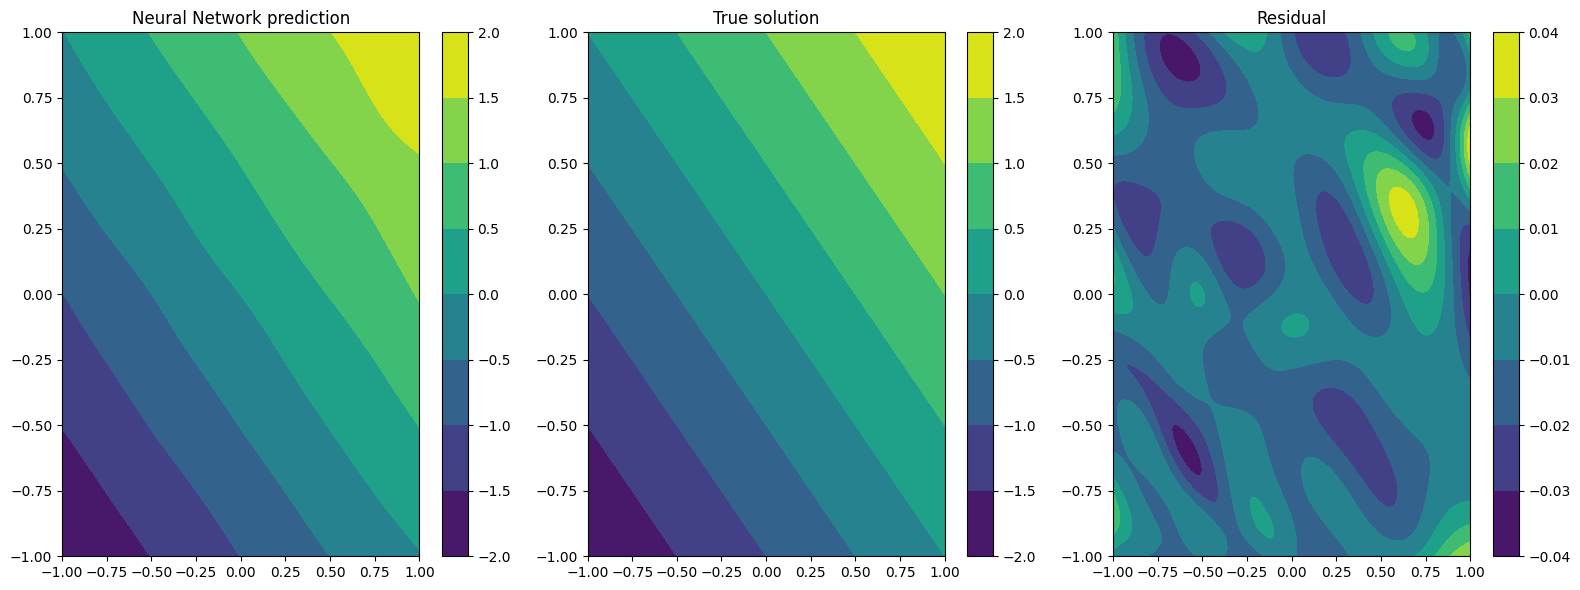

Plotting at t=5


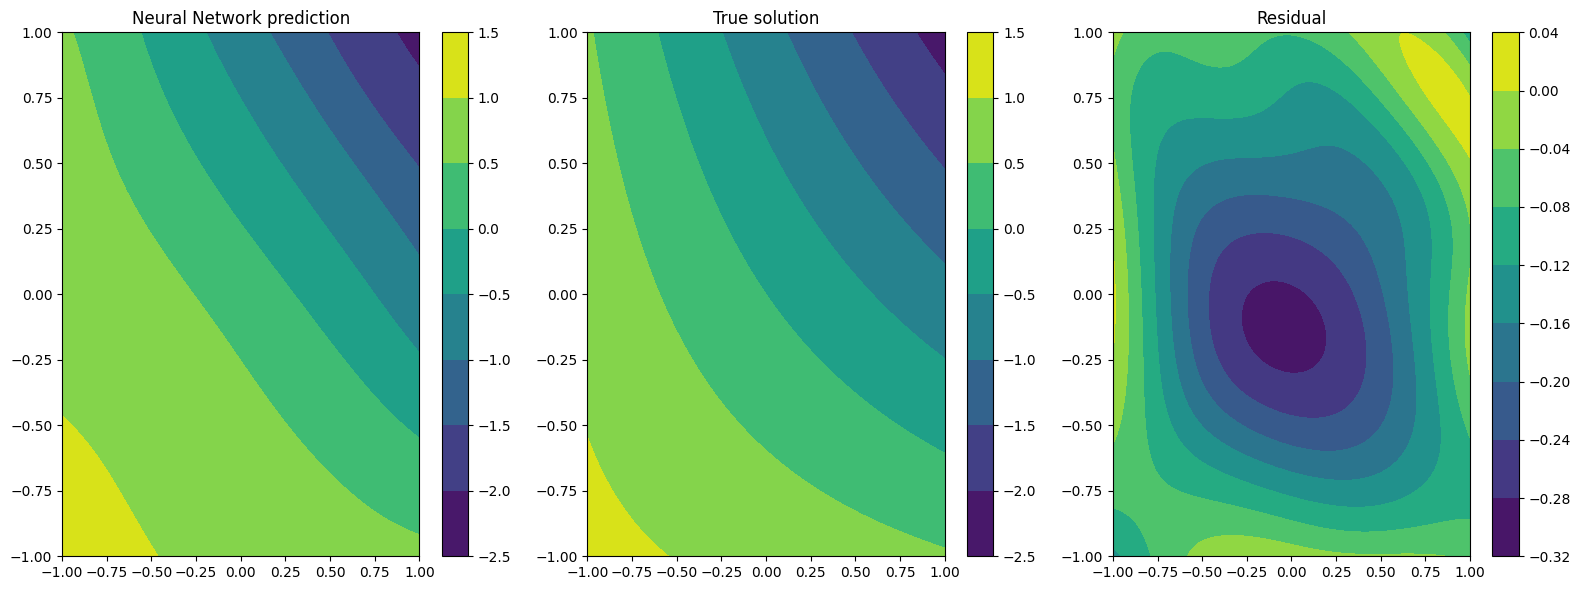

Plotting at t=10


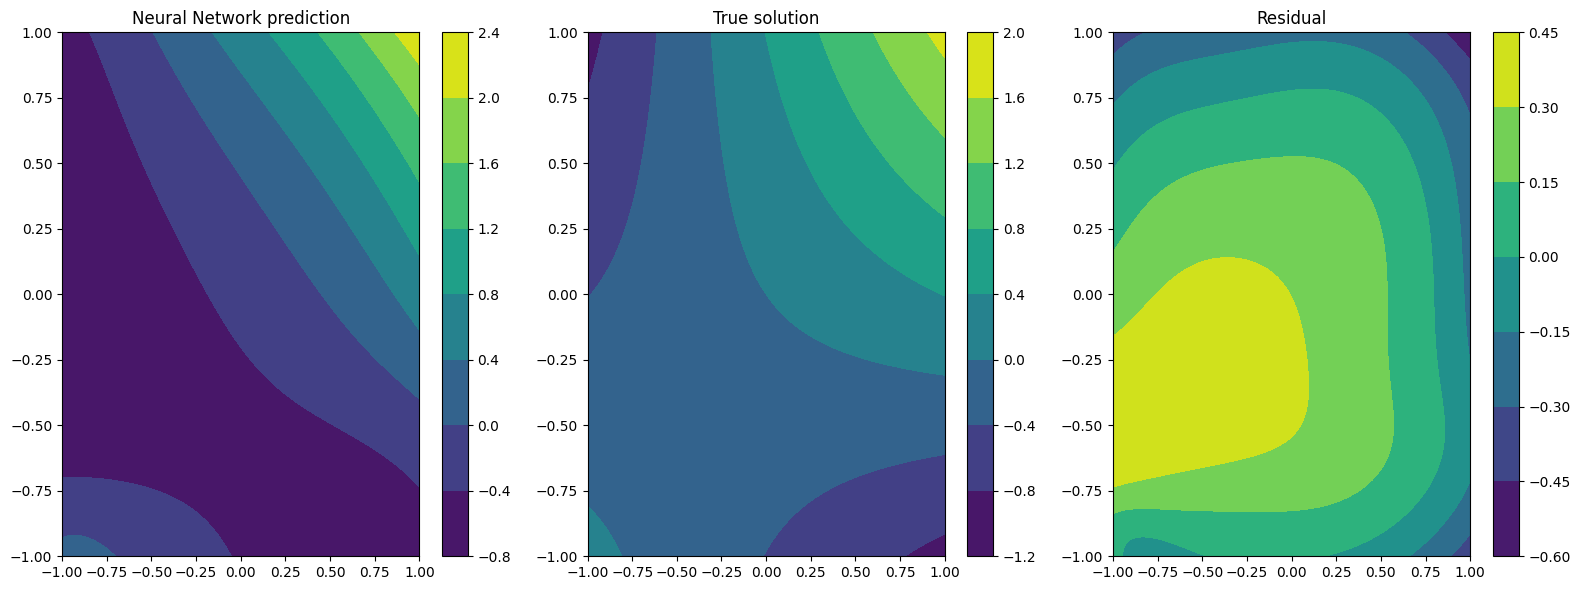

In [11]:
plotter = Plotter()

# plotting at fixed time t = 0.0
print('Plotting at t=0')
plotter.plot(pinn, fixed_variables={'t': 0.0})

# plotting at fixed time t = 0.5
print('Plotting at t=5')
plotter.plot(pinn, fixed_variables={'t':5})

# plotting at fixed time t = 1.
print('Plotting at t=10')
plotter.plot(pinn, fixed_variables={'t': 10})

In [12]:
truth_output.shape

NameError: name 'truth_output' is not defined

In [ ]:
predicted_output.shape

In [ ]:
error